D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


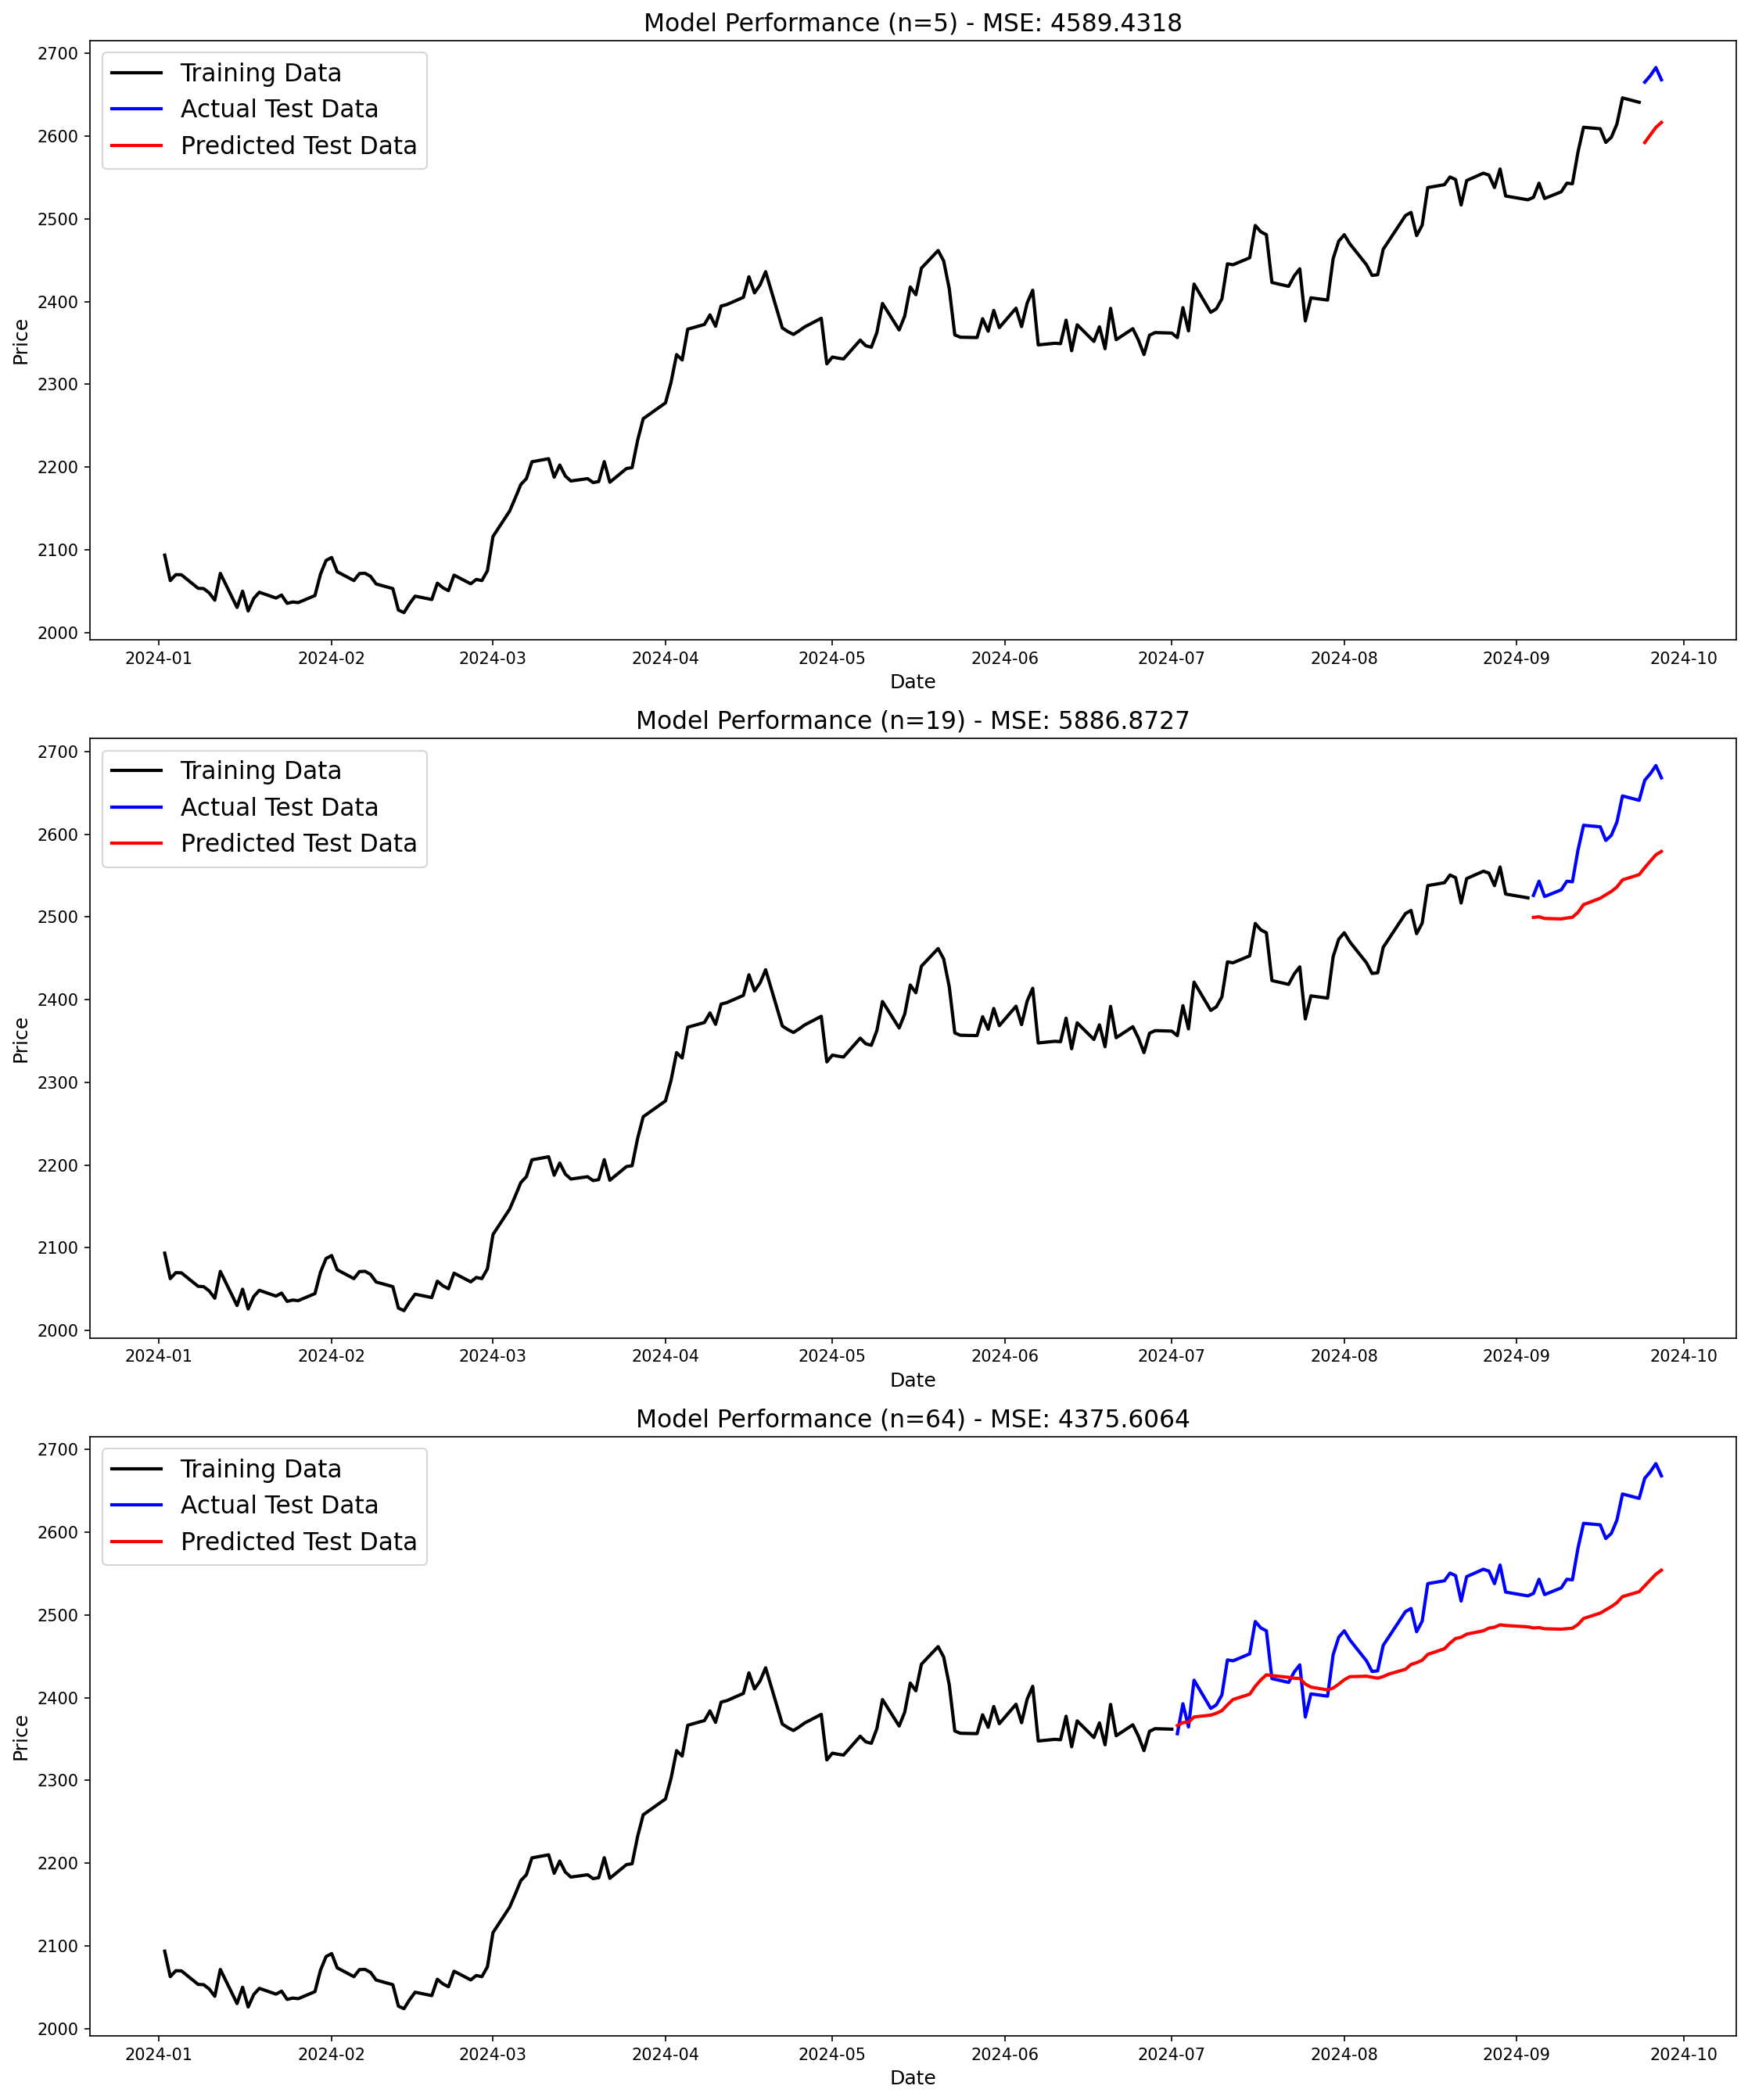

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import tensorflow as tf

# 读取CSV文件
df = pd.read_csv('黄金期货历史日数据到2024.csv')

# 数据预处理
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', inplace=True)
df.reset_index(drop=True, inplace=True)
df['Price'] = df['Price'].astype(float)

# 数据标准化
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df['Price'].values.reshape(-1,1))

# 定义测试集大小
ns = [5, 19, 64]

# 构建序列数据
window_size = 60
fig, axes = plt.subplots(len(ns), 1, figsize=(15, 6 * len(ns)), dpi=150)

for i, n in enumerate(ns):
    X, y = [], []
    for j in range(window_size, len(scaled_data) - n):
        X.append(scaled_data[j-window_size:j, 0])
        y.append(scaled_data[j, 0])
    X = np.array(X)
    y = np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # 定义模型
    model = Sequential()
    model.add(LSTM(64, input_shape=(window_size, 1)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs=50, batch_size=32, validation_split=0.1, verbose=0)

    # 准备测试数据
    X_test, y_test = [], []
    for j in range(len(scaled_data) - n + 1, len(scaled_data)):
        X_test.append(scaled_data[j-window_size+1:j+1, 0]) 
        y_test.append(scaled_data[j, 0])
    if X_test:
        X_test = np.array(X_test)
        y_test = np.array(y_test)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

        # 预测测试数据
        y_test_pred = model.predict(X_test)

        # 反标准化预测值
        y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))
        y_test_pred = scaler.inverse_transform(y_test_pred)

        # 计算MSE
        MSE = mean_squared_error(y_test_true, y_test_pred)

        # 绘制模型性能
        axes[i].plot(df['Date'][:-len(y_test_true)], scaler.inverse_transform(scaled_data[:-len(y_test_true)].reshape(-1, 1)), color='black', lw=2)
        axes[i].plot(df['Date'][-len(y_test_true):], y_test_true, color='blue', lw=2)
        axes[i].plot(df['Date'][-len(y_test_true):], y_test_pred, color='red', lw=2)
        axes[i].set_title(f'Model Performance (n={n}) - MSE: {MSE:.4f}', fontsize=15)
        axes[i].set_xlabel('Date', fontsize=12)
        axes[i].set_ylabel('Price', fontsize=12)
        axes[i].legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
        axes[i].grid(color='white')

plt.tight_layout()
plt.show()